Libraries

# iFood CRM Data Analyst Case

## The objective
The objective of the team is to build a predictive model that will produce the highest profit for the  next direct marketing campaign, scheduled for the next month. The new campaign, sixth, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving 2.240
customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled.

## The data
The data set contains socio-demographic and firmographic features about 2.240 customers who were contacted. Additionally, it contains a flag for those customers who responded the campaign, by buying the product.

## Deliverables
The following are the minimum required deliverables:
1. Explore the data – be creative and pay attention to the details. You need to provide the marketing team a better understanding of the characteristic features of respondents;
2. Create and describe a customer segmentation based on customers behaviors;
3. Create and describe a predictive model (classification) which allows the company to maximize the profit of the next marketing campaign.



---



## Exploring the data

Exploration of the data will be crucial to understand the data. Then, on the next step, we can proceed with the data cleaning based on our exploration results. And after that we can do some analysis.

In [ ]:
# Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import graphviz

First look at our file:

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/ifood-data-business-analyst-test-master/ml_project1_data.csv'
df_campaign = pd.read_csv(filepath)
df_campaign.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


Let's take a deep look at the data:

In [ ]:
df_campaign.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


From this result above we can identify some possible problems that can be worth to deeply investigate:

1. Min Year_Birth is 1893, which seems unlikely to be true;
2. Max Income is 666666, which seens to be way greater than the values we see in this column;
3. Income count is only 2216, which means that we have some nulls, not many;
4. We have the columns Z_CostContact and Z_Revenue which are not in the data dictionary;

Let's further investigate this problems to understand if they really are problems.


We'll separate the dataframe into numerical and categorical to further understand each column.

In [ ]:
df_campaign.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [ ]:
df_campaign_numerical = df_campaign[['Year_Birth','Income','Kidhome','Teenhome', 
                                     'Recency', 'MntWines', 'MntFruits', 
                                     'MntMeatProducts', 'MntFishProducts',
                                     'MntSweetProducts', 'MntGoldProds', 
                                     'NumDealsPurchases', 'NumWebPurchases', 
                                     'NumCatalogPurchases', 'NumStorePurchases',
                                     'NumWebVisitsMonth']]
df_campaign_categorical = df_campaign[['Education', 'Marital_Status', 'Dt_Customer', 
                                       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                                       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 
                                       'Response']]

Let's create a histogram for each numerical column:

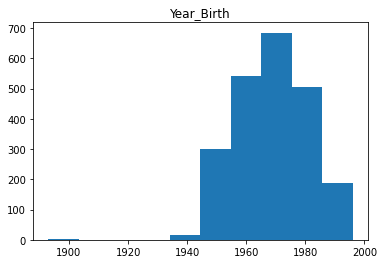

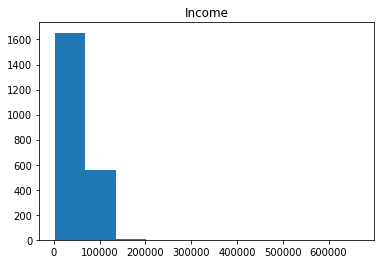

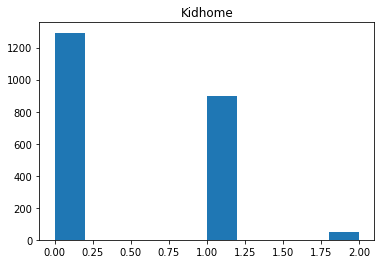

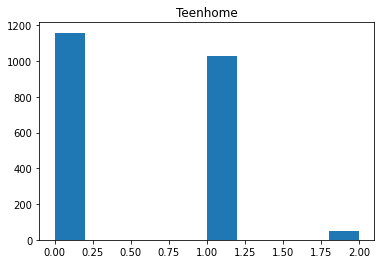

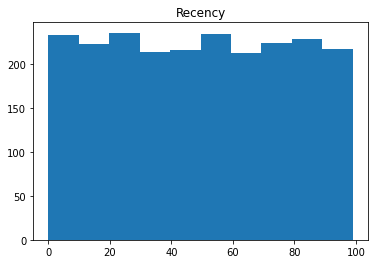

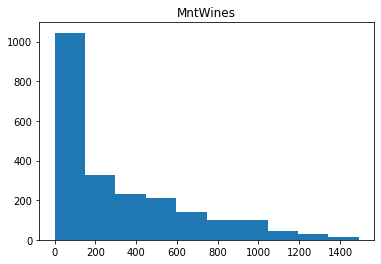

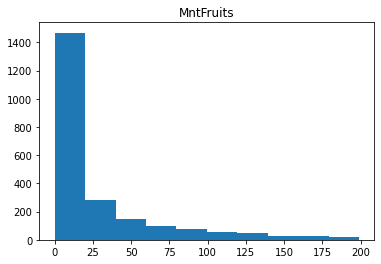

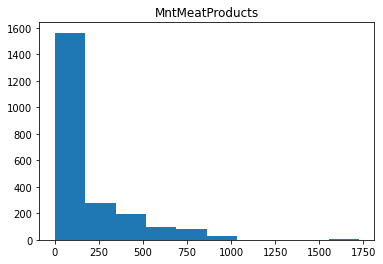

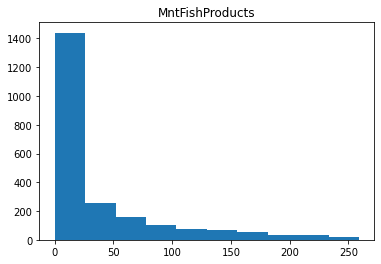

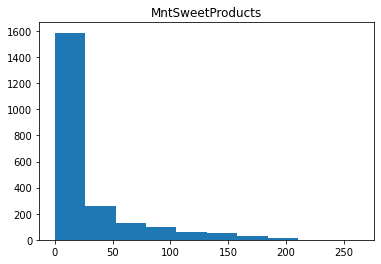

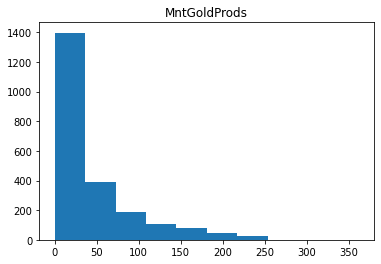

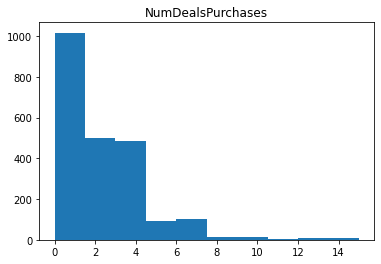

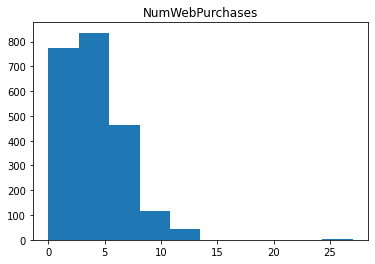

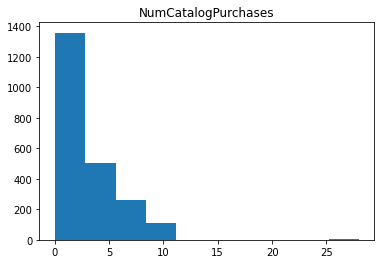

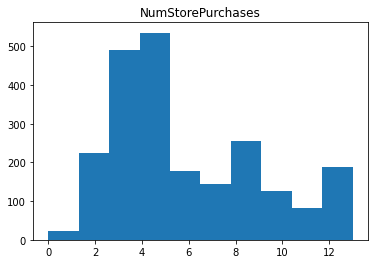

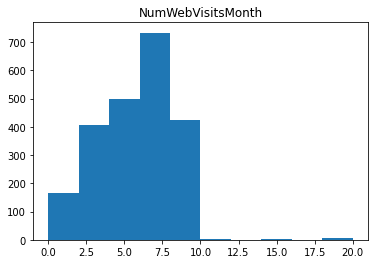

In [ ]:
for column in df_campaign_numerical.columns:
    plt.hist(df_campaign_numerical[column])
    plt.title(column)
    plt.show()

And now a bar chart for each categorical column:

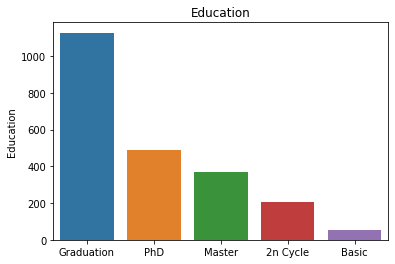

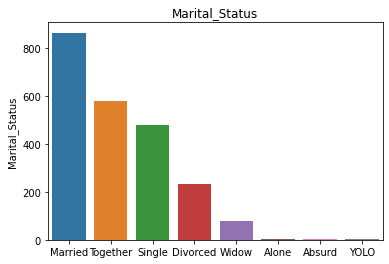

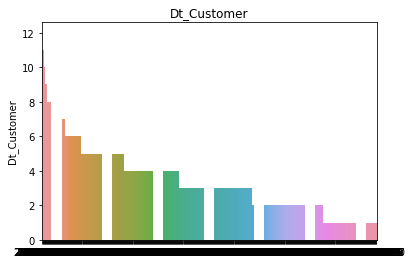

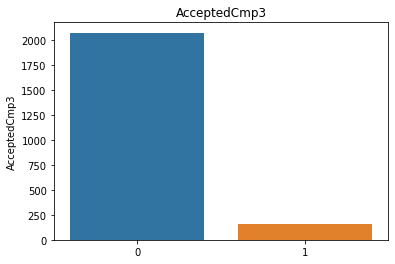

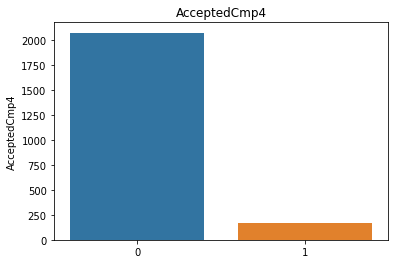

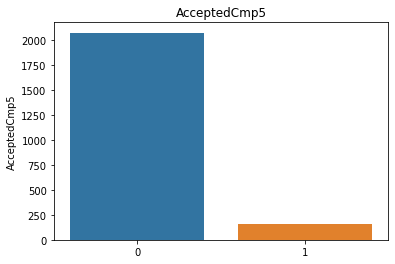

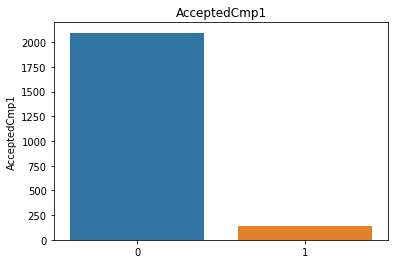

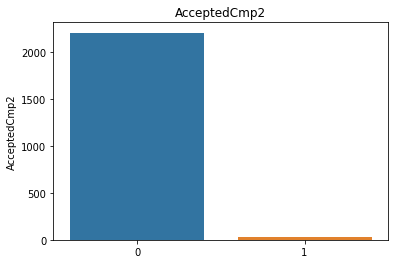

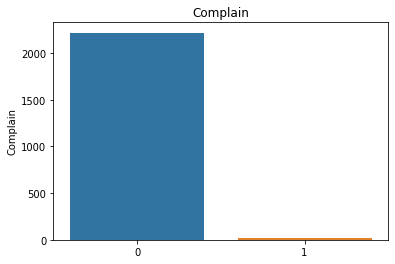

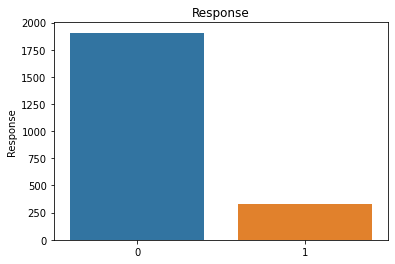

In [ ]:
for column in df_campaign_categorical.columns:
    sns.barplot(
        x=df_campaign_categorical[column].value_counts().index, 
        y=df_campaign_categorical[column].value_counts()
    ).set_title(column)
    plt.show()

By investigating these charts we can address more possible problems:

5. MntMeatProducts, NumWebPurchases, NumCatalogPurchases, NumWebVisitsMonth seems to have outliers;
6. Marital_Status have strange values such as Alone, YOLO and Absurd;
7. Marital_Status Married and Together could be the same thing. Single and Alone too.


Checking if we have duplicated IDs, we find that every line of that represents a different customer as should be.

In [ ]:
df_campaign['ID'].nunique()

2240

So now we'll take a look at those possible problems we addressed.
1. **Min Year_Birth is 1893, which seems unlikely to be true;**

Let's check our oldest customers:

In [ ]:
df_campaign.nsmallest(5, 'Year_Birth')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,3,11,0
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,3,11,0
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,3,11,0
1950,6663,1940,PhD,Single,51141.0,0,0,2013-07-08,96,144,0,7,0,0,6,1,3,1,4,5,0,0,0,0,0,0,3,11,0
424,6932,1941,PhD,Married,93027.0,0,0,2013-04-13,77,1285,42,716,55,0,21,0,7,10,5,2,0,0,1,0,0,0,3,11,0


Those first 3 customers (ID 239, 339 and 192) are way too old. The column Dt_Customer confirms that because it is unlikely that someone enrolls as costumer with more than 110 years. We will drop those on our Data Cleaning step.

Moving for those problems related with Income:

2. **Max Income is 666666, which seens to be way greater than the values we see in this column;**
3. **Income count is only 2216, which means that we have some nulls, not many;**

In [ ]:
df_campaign.nlargest(5, 'Income')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,14,18,8,1,12,4,3,1,3,6,0,0,0,0,0,0,3,11,0
617,1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,1,16,2,1,2,0,0,0,1,1,0,0,0,0,0,0,3,11,0
687,1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,3,11,0
1300,5336,1971,Master,Together,157733.0,1,0,2013-06-04,37,39,1,9,2,0,8,0,1,0,1,1,0,0,0,0,0,0,3,11,0
164,8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,3,11,0


As we thought 666666 if way off the pattern. It is safe to drop this value as well.

In [ ]:
df_campaign.loc[df_campaign['Income'].isna()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,5,6,0,2,1,1,1,0,2,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,263,362,0,27,0,0,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,2013-11-05,80,81,11,50,3,2,39,1,1,3,4,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,5,48,6,10,7,3,2,1,4,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,3,22,2,2,6,2,2,0,3,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,3,43,17,4,17,3,3,0,3,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,42,192,49,37,53,12,7,2,8,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,0,8,2,0,1,1,1,0,2,7,0,0,0,0,0,0,3,11,0
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445,37,359,98,28,18,1,2,4,8,1,0,0,0,0,0,0,3,11,0
128,8268,1961,PhD,Married,NaN,0,1,2013-07-11,23,352,0,27,10,0,15,3,6,1,7,6,0,0,0,0,0,0,3,11,0


They seem to be legit customers, that may have felt loke not giving that Marital Status for personal reasons. Let's only remove this field from them.

Everything looks good with these data, and it is not many rows compared to the whole dataset, so it is safe to fill those with the median as usual.

Moving to the next one:

4. **We have the columns Z_CostContact and Z_Revenue which are not in the data dictionary;**

We'll drop these columns since we do not have the exact definitions of them on the data mapping.

Next:

5. **MntMeatProducts, NumWebPurchases, NumCatalogPurchases, NumWebVisitsMonth seems to have outliers;**

First with MntMeatProducts, we'll use a larger sample now:




In [ ]:
df_campaign.nlargest(10, 'MntMeatProducts')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
21,5376,1979,Graduation,Married,2447.0,1,0,2013-01-06,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,0,0,0,0,3,11,0
1653,4931,1977,Graduation,Together,157146.0,0,0,2013-04-29,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,3,11,0
687,1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,3,11,0
2228,8720,1978,2n Cycle,Together,NaN,0,0,2012-08-12,53,32,2,1607,12,4,22,0,0,0,1,0,0,1,0,0,0,0,3,11,0
164,8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,3,11,0
1358,1065,1963,Graduation,Single,80695.0,0,0,2013-12-29,85,557,129,984,193,37,18,1,5,8,5,2,0,0,0,0,0,0,3,11,0
1808,1619,1956,Graduation,Married,90369.0,0,0,2014-04-28,2,292,51,981,224,23,17,1,4,6,6,1,0,0,0,0,0,0,3,11,1
456,4947,1966,2n Cycle,Single,89572.0,0,0,2012-09-15,44,606,24,974,197,194,64,1,7,7,9,4,0,1,0,1,0,0,3,11,1
2109,3104,1961,Graduation,Single,82332.0,0,0,2012-09-17,89,830,59,968,51,79,19,1,5,3,12,2,0,0,1,0,0,0,3,11,1
1031,9220,1971,Graduation,Single,91700.0,0,0,2013-01-17,58,576,172,961,125,115,19,1,8,6,5,3,0,0,0,0,0,0,3,11,1


Seems ok, since those 5 outliers are also the highest income customers. No action needed.

In [ ]:
df_campaign.nlargest(10, 'NumWebPurchases')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,263,362,0,27,0,0,1,0,0,0,0,0,0,3,11,0
1898,4619,1945,PhD,Single,113734.0,0,0,2014-05-28,9,6,2,3,1,262,3,0,27,0,0,1,0,0,0,0,0,0,3,11,0
1975,10311,1969,Graduation,Married,4428.0,0,1,2013-10-05,0,16,4,12,2,4,321,0,25,0,0,1,0,0,0,0,0,0,3,11,0
1806,6237,1966,PhD,Single,7144.0,0,2,2013-12-07,92,81,4,33,5,2,291,0,23,1,1,0,0,0,0,0,0,0,3,11,0
18,6565,1949,Master,Married,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,3,11,0
67,9369,1979,2n Cycle,Single,88194.0,0,1,2014-03-19,19,688,14,309,201,24,38,1,11,10,10,5,1,0,0,1,0,0,3,11,1
131,433,1958,Master,Alone,61331.0,1,1,2013-03-10,42,534,5,47,0,5,41,5,11,1,6,8,0,0,0,0,0,0,3,11,0
175,8717,1975,PhD,Married,80427.0,0,1,2012-09-12,56,1149,71,449,69,71,26,1,11,8,8,5,0,0,0,0,0,0,3,11,0
202,8727,1978,Graduation,Divorced,63693.0,0,1,2013-10-14,63,587,43,337,42,87,54,3,11,6,9,6,0,0,0,0,0,0,3,11,0
209,380,1954,Graduation,Divorced,64497.0,0,1,2012-09-10,17,1170,48,320,42,32,192,5,11,4,9,8,1,0,0,0,0,0,3,11,1


Seem ok too.

In [ ]:
df_campaign.nlargest(10, 'NumCatalogPurchases')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
21,5376,1979,Graduation,Married,2447.0,1,0,2013-01-06,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,0,0,0,0,3,11,0
687,1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,3,11,0
1653,4931,1977,Graduation,Together,157146.0,0,0,2013-04-29,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,3,11,0
164,8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,3,11,0
104,8908,1959,Graduation,Married,87195.0,0,0,2014-05-08,35,217,76,690,50,26,38,1,3,11,5,1,0,0,0,0,0,0,3,11,1
288,10102,1966,Graduation,Widow,79946.0,0,0,2014-05-12,19,395,183,565,166,141,28,1,5,11,5,3,0,0,0,0,0,0,3,11,0
586,9058,1955,Graduation,Widow,79800.0,0,0,2012-09-23,65,1060,21,530,32,0,224,1,5,11,5,3,1,0,1,1,0,0,3,11,1
591,7627,1975,Master,Married,92163.0,0,0,2012-12-12,25,817,183,797,106,163,20,0,5,11,5,2,0,0,1,1,0,0,3,11,1
627,4299,1960,Graduation,Together,70971.0,0,1,2012-09-21,28,1001,17,572,93,125,17,7,11,11,5,7,0,0,0,0,0,0,3,11,1
636,6945,1952,Graduation,Single,84574.0,0,0,2013-06-04,72,387,20,713,38,54,163,1,9,11,11,5,0,0,0,0,0,0,3,11,0


Seems strange to have the highest catalogue buyer to be one of the lowest Income. I would drop that record too.

In [ ]:
df_campaign.nlargest(10, 'NumWebVisitsMonth')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0
774,4303,1957,PhD,Together,6835.0,0,1,2012-12-08,76,107,2,12,2,2,12,0,0,0,1,20,0,0,0,0,0,0,3,11,0
1245,6862,1971,Graduation,Divorced,1730.0,0,0,2014-05-18,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,3,11,0
1042,10749,1991,Graduation,Single,8028.0,0,0,2012-09-18,62,73,18,66,7,12,2,15,0,1,0,19,0,0,0,0,0,0,3,11,0
1846,9931,1963,PhD,Married,4023.0,1,1,2014-06-23,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,3,11,0
1328,4246,1982,Master,Single,6560.0,0,0,2013-12-12,2,67,11,26,4,3,262,0,1,0,1,17,0,0,0,0,0,0,3,11,0
981,3955,1965,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0
1524,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0
2214,9303,1976,Graduation,Married,5305.0,0,1,2013-07-30,12,12,4,7,1,3,5,0,1,0,0,13,0,0,0,0,0,0,3,11,0
47,7286,1968,Graduation,Together,41728.0,1,0,2013-05-24,92,13,6,15,3,5,13,1,2,0,2,10,0,0,0,0,0,0,3,11,0


Seems ok.

Sixth indentified possible problem:

6. **Marital_Status have strange values such as Alone, YOLO and Absurd;**





In [ ]:
df_campaign.loc[df_campaign['Marital_Status'].isin(['Alone', 'YOLO', 'Absurd'])]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
131,433,1958,Master,Alone,61331.0,1,1,2013-03-10,42,534,5,47,0,5,41,5,11,1,6,8,0,0,0,0,0,0,3,11,0
138,7660,1973,PhD,Alone,35860.0,1,1,2014-05-19,37,15,0,8,4,2,20,2,1,1,2,5,1,0,0,0,0,0,3,11,1
153,92,1988,Graduation,Alone,34176.0,1,0,2014-05-12,12,5,7,24,19,14,20,4,3,0,4,6,0,0,0,0,0,0,3,11,0
2093,7734,1993,Graduation,Absurd,79244.0,0,0,2012-12-19,58,471,102,125,212,61,245,1,4,10,7,1,0,0,1,1,0,0,3,11,1
2134,4369,1957,Master,Absurd,65487.0,0,0,2014-01-10,48,240,67,500,199,0,163,3,3,5,6,2,0,0,0,0,0,0,3,11,0
2177,492,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,50,4,3,42,5,7,1,6,8,0,0,0,0,0,0,3,11,0
2202,11133,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,50,4,3,42,5,7,1,6,8,0,0,0,0,0,0,3,11,1


Data seems ok, but we'll drop YOLO and Absurd since these customers acted in bad faith.

7. **Marital_Status Married and Together could be the same thing. Single and Alone too.**

We'll handle this inside the Feature Engineering section.

## Data Cleaning

Let's see how many rows we have before the cleaning:

In [ ]:
print(len(df_campaign.index))

2240


Drop customers that were identified as too old to be true customers.

In [ ]:
df_campaign.drop(df_campaign.loc[df_campaign['ID'].isin(['239', '339', '192'])].index, inplace=True)
print(len(df_campaign.index))

2239


Replace 666666 income with null and fill nulls in with median.

In [ ]:
print("NaN Count Before:", df_campaign['Income'].isna().sum())
df_campaign['Income'].replace(666666, np.nan, inplace=True)
print("Max Income:", df_campaign['Income'].max())
print("NaN Count After Removing 666666:", df_campaign['Income'].isna().sum())
df_campaign['Income'].fillna(df_campaign['Income'].median(), inplace=True)
print("NaN Count Final:", df_campaign['Income'].isna().sum())

NaN Count Before: 24
Max Income: 162397.0
NaN Count After Removing 666666: 25
NaN Count Final: 0


Drop column Z_CostContact and Z_Revenue since we do not have their definitions.

In [ ]:
print("Columns before:", len(df_campaign.columns))
df_campaign.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
print("Columns after:", len(df_campaign.columns))

Columns before: 29
Columns after: 27


Drop customer ID 5376 because he is the highest catalog buyer but he has too low income.

In [ ]:
df_campaign.drop(df_campaign.loc[df_campaign['ID'] == 5376].index, inplace=True)
print(len(df_campaign.index))

2238


Drop customers that were messing with the pool.

In [ ]:
df_campaign.drop(df_campaign.loc[df_campaign['Marital_Status'].isin(['YOLO', 'Absurd'])].index, inplace=True)
print(len(df_campaign.index))

2234


## Feature Engineering

Merge Married with Together and Single with Alone since they are basically the same.

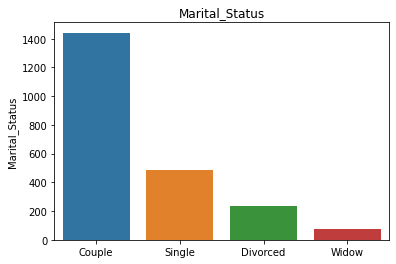

In [ ]:
df_campaign['Marital_Status'].replace(['Together', 'Married'], 'Couple', inplace=True)
df_campaign['Marital_Status'].replace(['Alone'], 'Single', inplace=True)
sns.barplot(
    x=df_campaign['Marital_Status'].value_counts().index, 
    y=df_campaign['Marital_Status'].value_counts()
).set_title('Marital_Status')
plt.show()

Done cleaning and engineering the features. Now let's refresh the data in some of the other dataframes we have.

In [ ]:
df_campaign_numerical = df_campaign[['Year_Birth','Income','Kidhome','Teenhome', 
                                     'Recency', 'MntWines', 'MntFruits', 
                                     'MntMeatProducts', 'MntFishProducts',
                                     'MntSweetProducts', 'MntGoldProds', 
                                     'NumDealsPurchases', 'NumWebPurchases', 
                                     'NumCatalogPurchases', 'NumStorePurchases',
                                     'NumWebVisitsMonth']]
df_campaign_categorical = df_campaign[['Education', 'Marital_Status', 'Dt_Customer', 
                                       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                                       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 
                                       'Response']]

Let's check if we have features that have a very high correlation that could mean we could drop one of them (simplify the dataset) and not lose much in information.

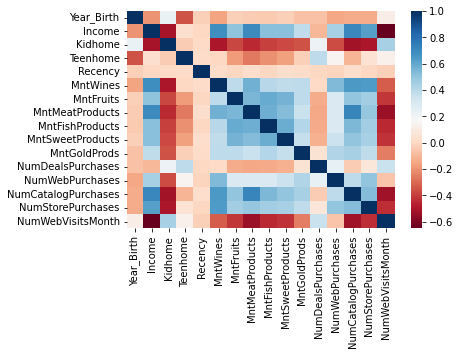

In [ ]:
sns.heatmap(df_campaign_numerical.corr(), cmap='RdBu')

The only two features that seems to have high correlations are MntMeatProducts and NumCatalogPurchases. Maybe because the only products that this company sells in catalog are related to meat. I'll not drop any other column.

## Customer Segmentation and Model

Now that we have a clean dataset, let's check if we find any valuable information in them.

Checking how marital status influences in the response to the campaing.

In [ ]:
def  generate_stacked_bar_char_categorical_vs_response(df, column):
    x = df.groupby([column, 'Response']).size().reset_index(name ='Total Amount')
    x = pd.pivot_table(x, index = column, columns = 'Response', values = 'Total Amount')
    x = x.rename_axis(None, axis=1).reset_index()
    x.set_index(column, inplace=True)
    x.columns = x.columns.astype(str)
    x.rename(columns={'0': 'Not Bought', '1': 'Bought'}, inplace=True)

    y = df.groupby(column)['Response'].count().reset_index(name="0")
    y.set_index(column, inplace=True)
    y['1']  = y['0']
    y.rename(columns={'0': 'Not Bought', '1': 'Bought'}, inplace=True)

    x_div_y = x.div(y, axis=0,level=0)
    # Plot
    x_div_y.plot(kind='bar', ylabel='Customer Bought Percentage', stacked =True)

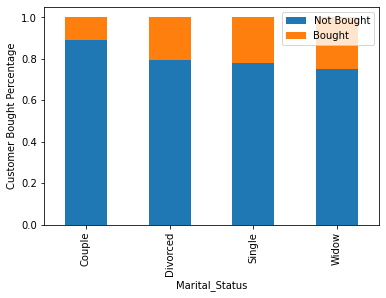

In [ ]:
generate_stacked_bar_char_categorical_vs_response(df_campaign, 'Marital_Status')

Checking how education influences in the response to the campaing.

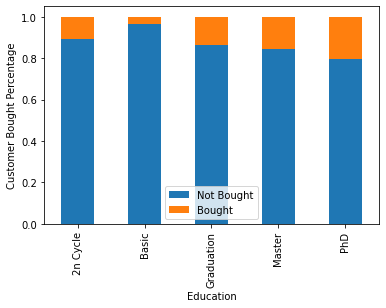

In [ ]:
generate_stacked_bar_char_categorical_vs_response(df_campaign, 'Education')

Some more cleaning before using a model to infere more information on the  data.

In [ ]:
pd.pivot_table(df_campaign, index = 'Response', values = df_campaign_numerical.columns)

,Income,Kidhome,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Year_Birth
Response,,,,,,,,,,,,,,,,
0,50541.229112,0.462428,34.928008,24.217551,40.924855,143.656858,25.072517,269.232790,2.377824,2.314766,5.739359,3.912769,5.323174,51.547031,0.541776,1968.697320
1,60170.471299,0.344411,51.851964,38.232628,61.123867,296.419940,38.791541,503.468278,4.202417,2.332326,6.096677,5.057402,5.293051,35.271903,0.302115,1969.326284


From this we find columns that seems to be irrelevant from the perspective of the Response. They are:

*   NumDealsPurchases
*   NumWebVisitsMonth
*   Year_Birth

We'll drop those before applying the data in the model.


In [ ]:
df_campaign.drop(['NumDealsPurchases', 'NumWebVisitsMonth', 'Year_Birth'], axis=1, inplace=True)
df_campaign_numerical.drop(['NumDealsPurchases', 'NumWebVisitsMonth', 'Year_Birth'], axis=1, inplace=True)

Applying in a decision tree classifier. This type of classifier was selected because of its simplicity and its capability of auditability. Other models models and classifiers give their results sometimes in a "magical way", using hyperplanes and other complex mathematical computations that humans hardly really comprehend, and thus, I'll not apply them here. Also I do not know them very well to apply here, so...  

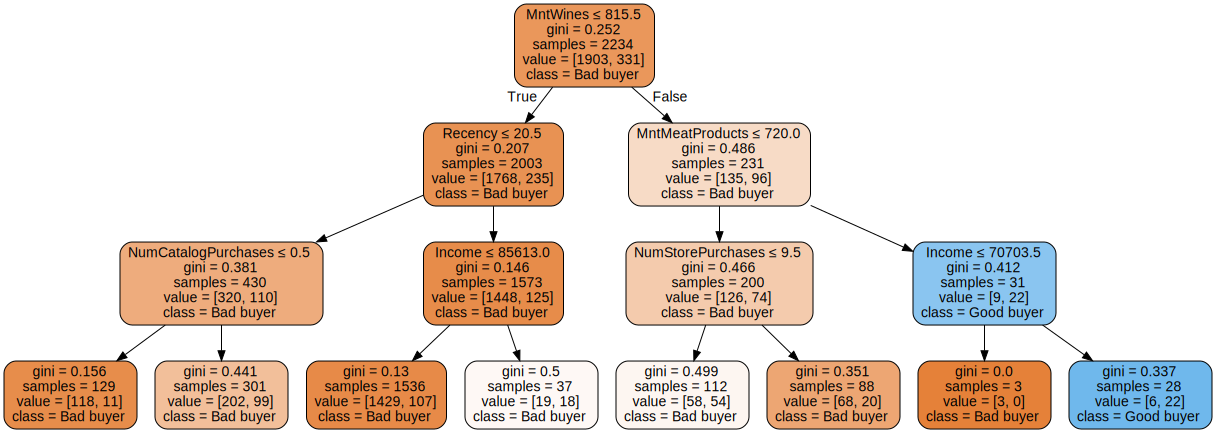

In [ ]:
x, y = df_campaign_numerical, df_campaign.Response
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x, y)

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=df_campaign_numerical.columns,  
                      class_names=['Bad buyer','Good buyer'],  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)  
graph  

I believe that it is out of scope of this document to explain how a decision tree works, but basically it tries to reduce entropy (randomness), and thus, it is able to classify the custumers. Looking at the tree above we see that good buyers are the ones that buys wine, buys meat and have high income. Let's analyse these fields.

Meat buyers, clustered in customers that spent more than \$700 in the previous two years, and those that spent less than \$700. We can  confirm that the percentage that buys are really higher in the cluster that  buys a lot of meat, around three times more.

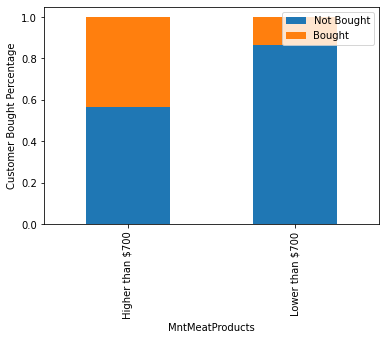

In [ ]:
df_copy = df_campaign.copy()
df_copy['MntMeatProducts'] = df_copy['MntMeatProducts'].apply(lambda x: 'Higher than $700' if x > 700 else 'Lower than $700')
generate_stacked_bar_char_categorical_vs_response(df_copy, 'MntMeatProducts')

Wine buyers, clustered in customers that spent more than \$800 in the previous two years, and those that spent less than \$800. We can  confirm that the percentage that buys are really higher in the cluster that  buys a lot of wine, at leat three times more.

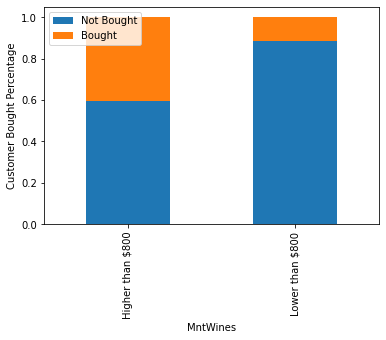

In [ ]:
df_copy = df_campaign.copy()
df_copy['MntWines'] = df_copy['MntWines'].apply(lambda x: 'Higher than $800' if x > 800 else 'Lower than $800')
generate_stacked_bar_char_categorical_vs_response(df_copy, 'MntWines')

People with income higher than \$70k buys at least two times more.

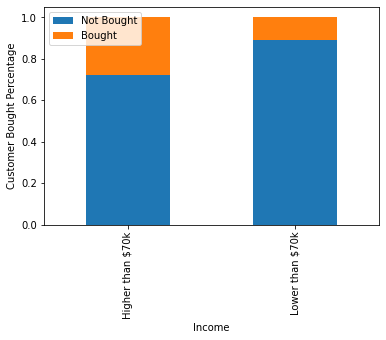

In [ ]:
df_copy = df_campaign.copy()
df_copy['Income'] = df_copy['Income'].apply(lambda x: 'Higher than $70k' if x > 70000 else 'Lower than $70k')
generate_stacked_bar_char_categorical_vs_response(df_copy, 'Income')

## Conclusion

We should aim the next marketing campaign to customers that have this profile:


*   Buys wine
*   Buys meat
*   Have high income
*   Is not in a romantic relationship  (single, widow, divorced)
*   Have a higher degree of education
  

